In [1]:
#import modules
import psycopg2 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import quad, nquad
from scipy.special import gamma
from math import log
import emcee
import corner
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [2]:
#loan status/recategorize into "good", "bad" = loan_status
#annual income = annual_inc, annual_inc_joint
#debt-to-income = dti
#interest rate = int_rate
#loan term = term
#funded amount = funded_amnt
#home ownership = home_ownership

In [3]:
#read in csv, set header at one bc first row is empty
data_1 = pd.read_csv('LoanStats3d.csv', header = 1)

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#set list of columns to be included in dataframe
cols = ['loan_status', 'annual_inc', 'dti', 'int_rate', 'term', 'funded_amnt','home_ownership']
#create dataframe only using columns indicated in above list
lending_df = data_1[cols]

In [5]:
lending_df.groupby('loan_status').size()

loan_status
Charged Off            24239
Current               303912
Default                   80
Fully Paid             76833
In Grace Period         4116
Late (16-30 days)       1925
Late (31-120 days)      9990
dtype: int64

In [6]:
loan_status = ['Default', 'Charged Off', 'Fully Paid']
#update dataframe to only include rows that have loan status included in list above
lending_df = lending_df[lending_df["loan_status"].isin(loan_status)]

In [7]:
#create function that removes percentage sign from column
def cleanpercent (x):
    if '%' in str(x):
        return str(x).strip('%')
    else:
        return x
#apply above function to int_rate column, convert to a float and divide by 100 (percentage value)
lending_df['int_rate'] = lending_df['int_rate'].apply(cleanpercent).astype(np.float64)/100

#create function strip word 'months' from column
def cleanmonth (x):
    if ' months' in str(x):
        return str(x).strip(' months')
    else:
        return x
#apply function to column 'term' in dataframe and convert type to float
lending_df['term'] = lending_df['term'].apply(cleanmonth).astype(np.float64)

#apply similar technique as above to 'home_ownership' column, in this case rent will be our dummy variable
#create two columns 'mortgage' and 'own'
lending_df['mortgage'] = np.where(lending_df['home_ownership']== "MORTGAGE", 1, 0)
lending_df['own'] = np.where(lending_df['home_ownership']== "OWN", 1, 0)

#also convert term values into classifiers
lending_df['term'] = np.where(lending_df['term']== 60., 1, 0)

In [8]:
#average interest rate for each specific loan status
lending_df.pivot_table(index= ['loan_status'], values = ['int_rate'])


,int_rate
loan_status,
Charged Off,0.157138
Default,0.150542
Fully Paid,0.126829


In [9]:
#data types for each column
lending_df.dtypes

loan_status        object
annual_inc        float64
dti               float64
int_rate          float64
term                int64
funded_amnt       float64
home_ownership     object
mortgage            int64
own                 int64
dtype: object

In [10]:
#create new column that gives binary outcome value to 'loan status' column, this is our classification variable
#seperate into good and bad loans, good = 'fully paid' and bad ='charged off' and 'default'
#our dummy variable in this case is bad loans, so we give a value of '1' to every row with 'fully paid' loan status
lending_df['fully_paid'] = np.where(lending_df['loan_status']== "Fully Paid", 1, 0)

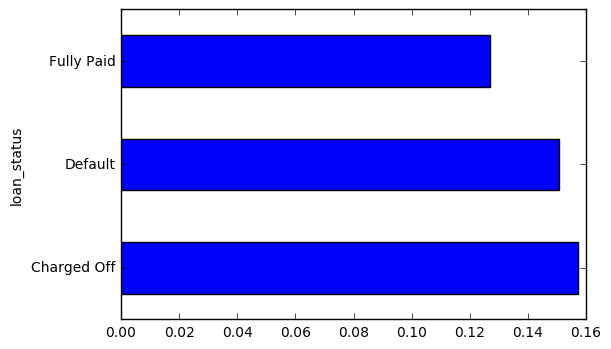

In [11]:
pd.pivot_table(lending_df, index="loan_status", values="int_rate", aggfunc=np.mean).plot(kind="barh")

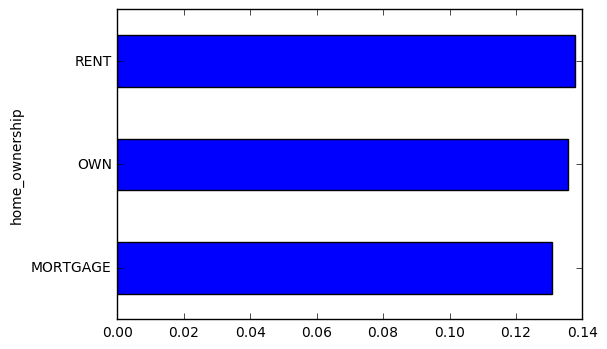

In [12]:
#interest rate for customers with particular home ownership
pd.pivot_table(lending_df, index="home_ownership", values="int_rate", aggfunc=np.mean).plot(kind="barh")

In [13]:
a = lending_df.pivot_table(index = 'dti', values = 'int_rate', aggfunc= np.mean)

In [14]:
#line graph of interest rate as function of dti
a = a.reset_index()

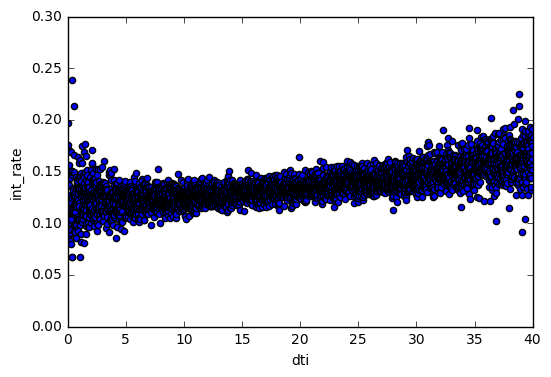

In [15]:
#a = a.to_frame()
a.plot(x='dti', y='int_rate', kind = 'scatter', xlim = (0,40))


In [16]:
import seaborn as sns

In [17]:
#select a random sample of 24319
good_df = lending_df.loc[lending_df['fully_paid'] == 1]
good_df = good_df.sample(n= 24319 )
bad_df = lending_df.loc[lending_df['fully_paid'] == 0]
lending_df = pd.concat([good_df, bad_df])


In [18]:
#create column that seperates customers into five different income brackets (arbitrarily decided by me)
lowincome_df = lending_df.loc[lending_df['annual_inc'] < 40000]
lmincome_df = lending_df.loc[lending_df['annual_inc'].isin(range(40000, 80000))]
midincome_df = lending_df.loc[lending_df['annual_inc'].isin(range(80000, 120000))]
mhincome_df = lending_df.loc[lending_df['annual_inc'].isin(range(120000, 160000))]
highincome_df = lending_df.loc[lending_df['annual_inc'] >= 160000]
lowincome_df['inc_bracket'] = "low"
lmincome_df['inc_bracket'] = "lm"
midincome_df['inc_bracket'] = "mid"
mhincome_df['inc_bracket'] = "mh"
highincome_df['inc_bracket'] = "high"
frames = [lowincome_df, lmincome_df, midincome_df, mhincome_df, highincome_df]
lending_df = pd.concat(frames)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

In [19]:
#convert a non-normalized dataframe into numpy matrix
#non_norm = lending_df.as_matrix()

In [20]:
#create list of columns to normalize
column_list = ['annual_inc', 'dti', 'int_rate', 'funded_amnt']
#define function to normalize data
def standard(x):
    return (x-mean_val)/(var_val**0.5)
#apply function to each of the columns in list
for y in column_list:
    mean_val = np.mean(lending_df[y])
    var_val = np.var(lending_df[y])
    lending_df[y] = lending_df[y].apply(standard)

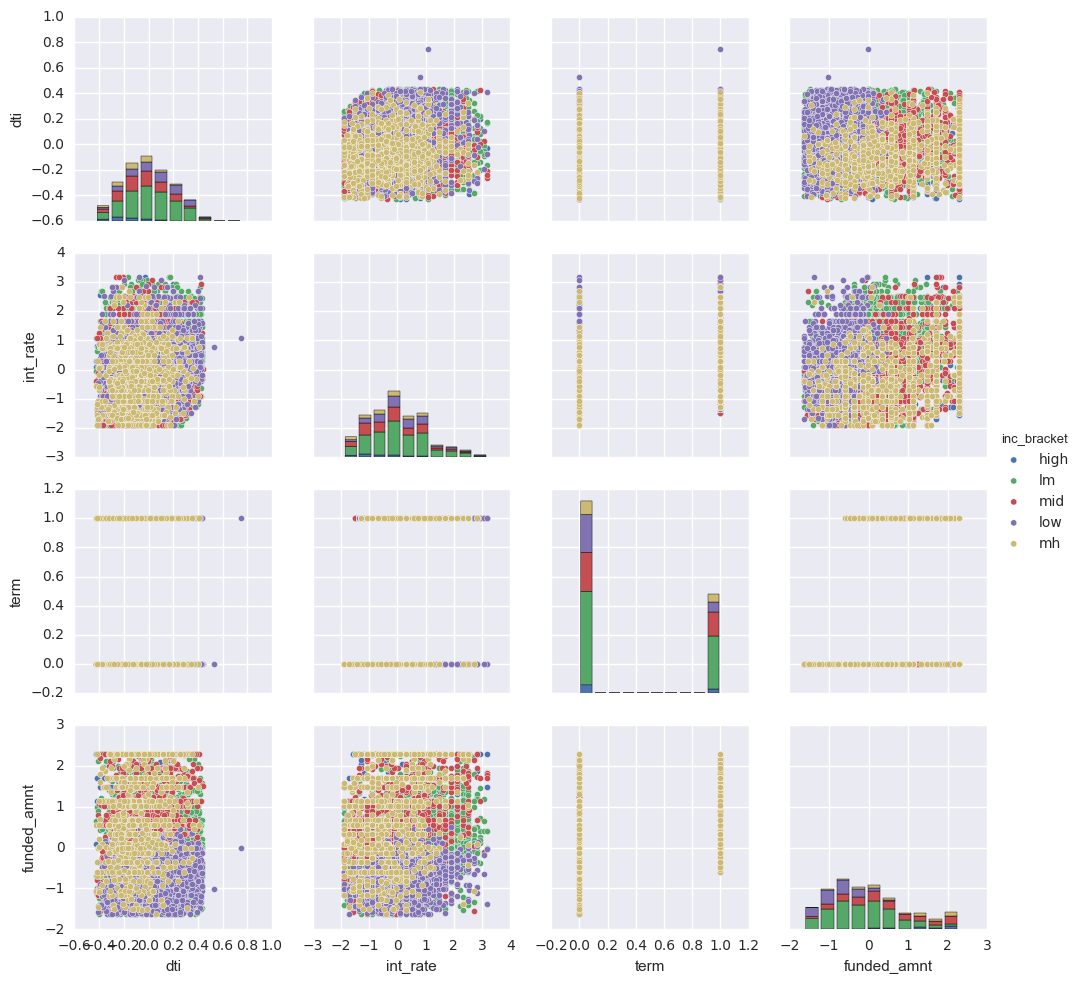

In [21]:
#pairplot that distinguishes data points by its income bracket
sns.pairplot(lending_df.sample(n = 10000), hue = "inc_bracket", vars=["dti" , "int_rate", "term", "funded_amnt"])

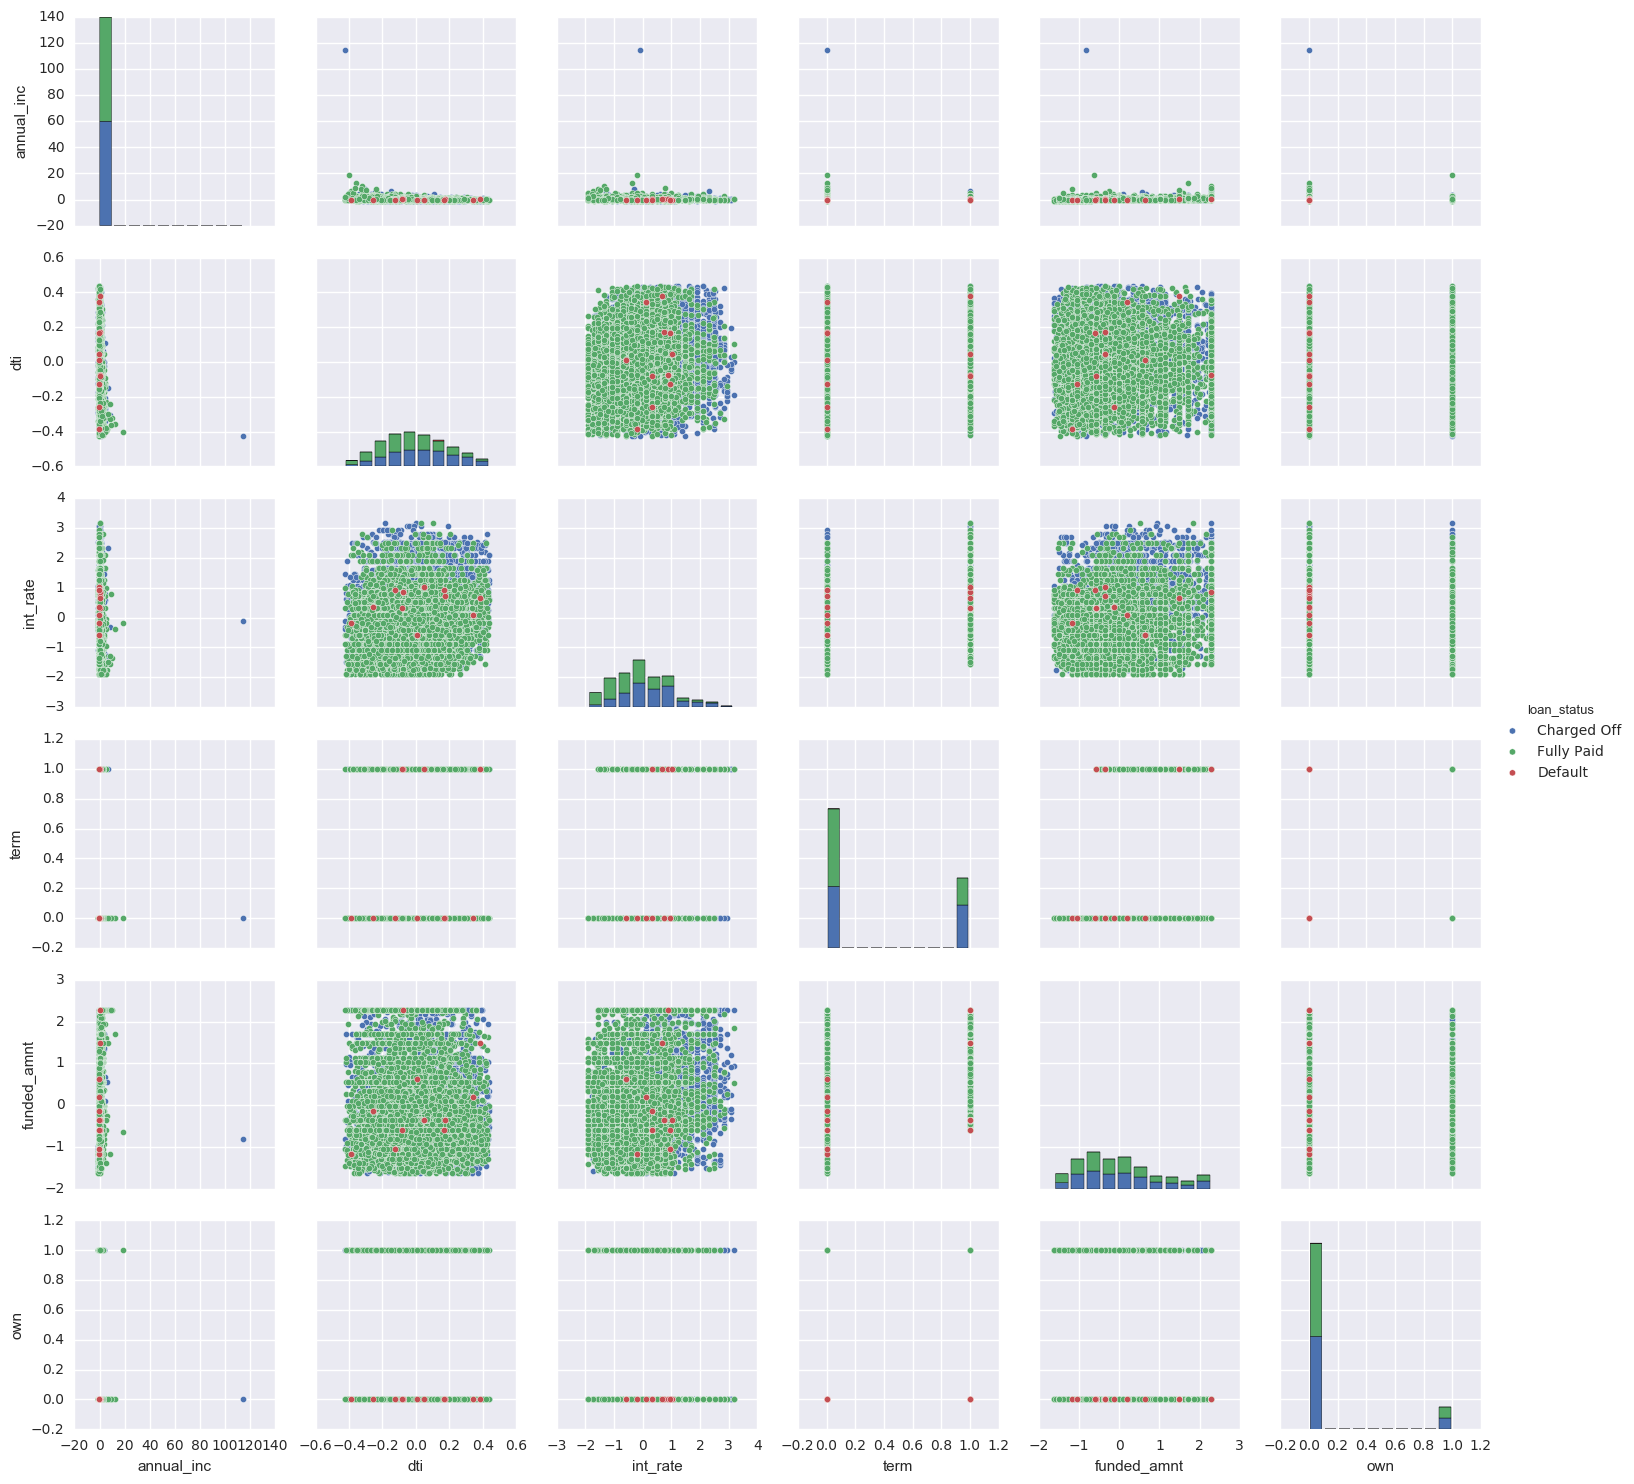

In [22]:
#and by loan status
sns.pairplot(lending_df.sample(n = 10000), hue = "loan_status", vars=["annual_inc", "dti" , "int_rate", "term", "funded_amnt", "own"])

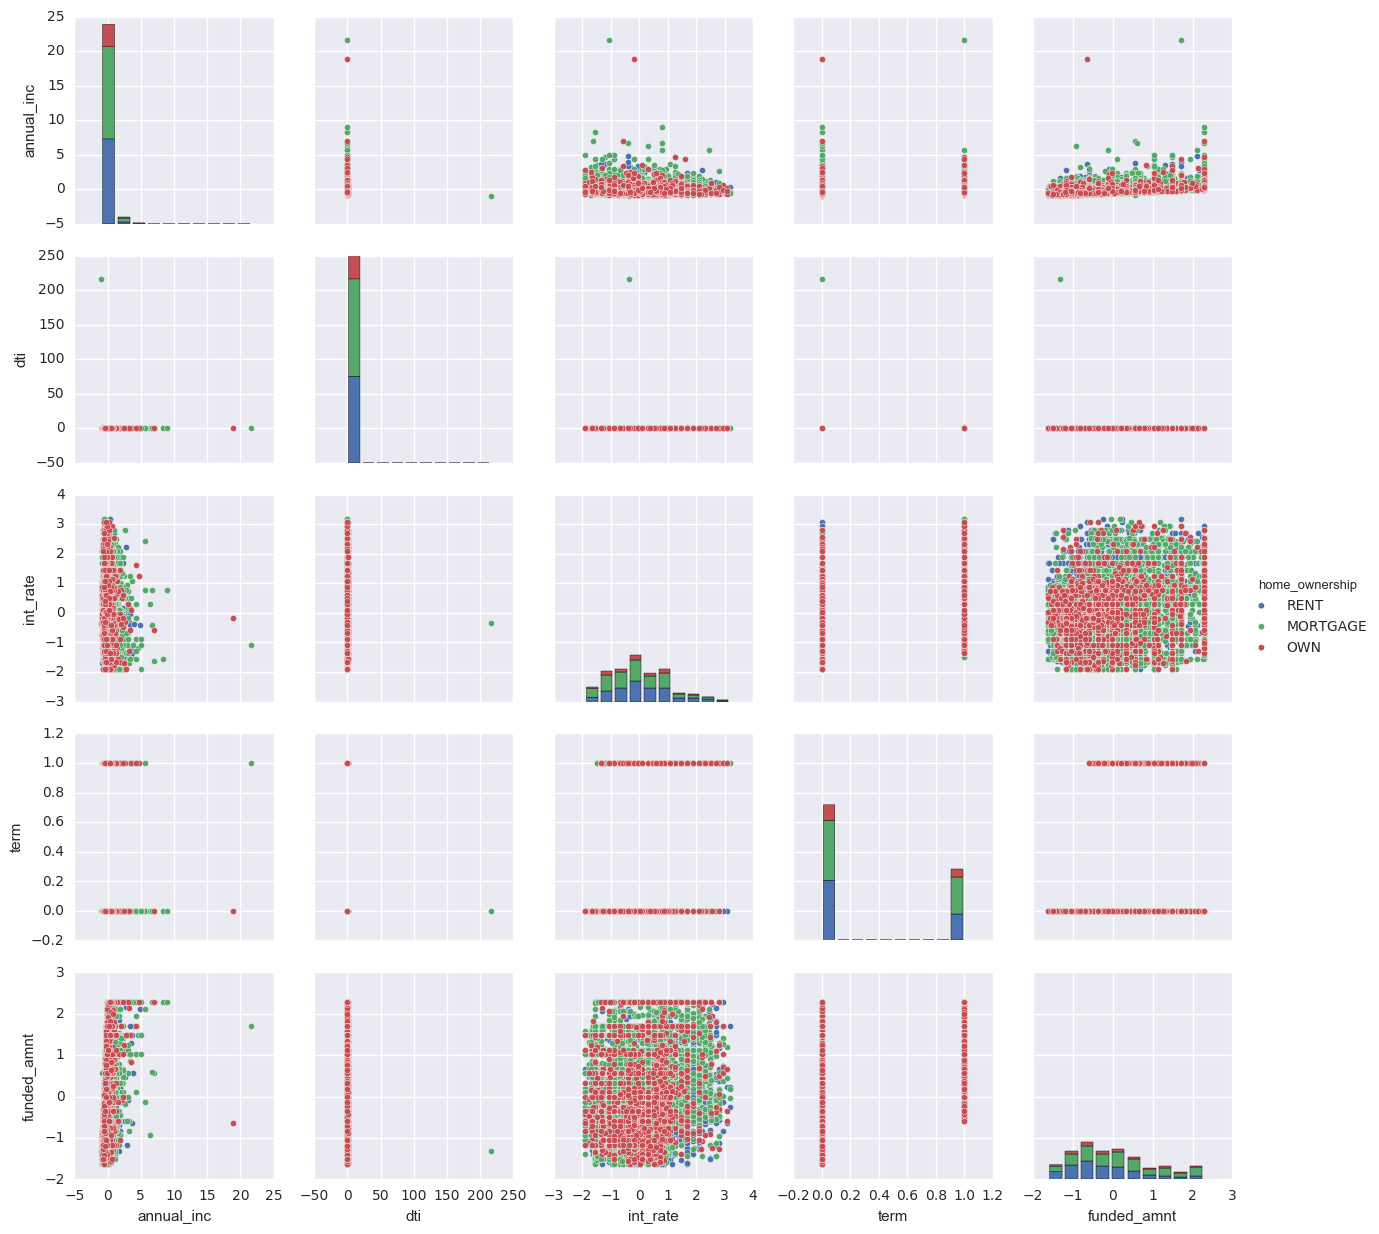

In [23]:
#and by home ownership
sns.pairplot(lending_df.sample(n = 10000), hue = "home_ownership", vars=["annual_inc", "dti" , "int_rate", "term", "funded_amnt"] )

In [24]:
pd.pivot_table(lending_df[["loan_status", "home_ownership"]], index =["loan_status", "home_ownership"], aggfunc=len)

loan_status  home_ownership
Charged Off  MORTGAGE           9824
             OWN                2746
             RENT              11543
Default      MORTGAGE             44
             OWN                   8
             RENT                 27
Fully Paid   MORTGAGE          12794
             OWN                2540
             RENT               8857
dtype: int64

In [25]:
#convert dataframe into numpy matrix
all_sub = lending_df.as_matrix()

In [26]:
from scipy.optimize import minimize

In [27]:
#import sigmoid function
sig = lambda x: 1./(1+np.exp(-x))


In [28]:
# log pred
def lnpred(a):
    for e in all_sub:
        pairedsum = a[0] + a[1]*e[1] + a[2]*e[2] + a[3]*e[3] + a[4]*e[4] + a[5]*e[5] + \
                a[6]*e[8] + a[7]*e[9]
        if e[7] == 1:
            return np.log(sig(pairedsum))
        else:
            return np.log(1 - sig(pairedsum))

# log posterior   
def lnprob(a):
    A2 = np.sum([e**2 for e in a])
    return -0.5*A2 + np.sum(lnpred(a))

nwalkers = 20
ndim = 8   #number of hyperparameters
p0 = np.random.rand(nwalkers*ndim).reshape((nwalkers,ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 10000)
samples = sampler.flatchain

def MonteCarlo(f, samples):
    N = len(samples)
    return 1/float(N)*sum([f(e) for e in samples])

omega0 = MonteCarlo(lambda x: x[0], samples)
omega1 = MonteCarlo(lambda x: x[1], samples)
omega2 = MonteCarlo(lambda x: x[2], samples)
omega3 = MonteCarlo(lambda x: x[3], samples)
omega4 = MonteCarlo(lambda x: x[4], samples)
omega5 = MonteCarlo(lambda x: x[5], samples)
omega6 = MonteCarlo(lambda x: x[6], samples)
omega7 = MonteCarlo(lambda x: x[7], samples)

print ('o0 = {0}, o1 = {1}, o2 = {2}, o3 = {3}, o4 = {4}, o5 = {5}, o6 = {6}, o7 = {7}').format(omega0, omega1, omega2, omega3, omega4, omega5, omega6, omega7)




o0 = 0.333258254893, o1 = -0.221280697012, o2 = -0.0818417288686, o3 = -0.0416573328554, o4 = 0.282021547902, o5 = -0.114219313726, o6 = 0.00441263650333, o7 = 0.312231982306


In [29]:
# get probability based on scaled data
def predict_prob(d1, d2, d3, d4, d5, d6, d7):
    return sig(omega0 + omega1*d1 + omega2*d2 + omega3*d3 + omega4*d4 + omega5*d5 \
              + omega6*d6 + omega7*d7)

predictive_prob = lambda x: MonteCarlo(lambda w: predict_prob(all_sub[x][1], all_sub[x][2] , \
                  all_sub[x][3], all_sub[x][4], all_sub[x][5], all_sub[x][8], all_sub[x][9]), samples)


def loanpred(x):
    if all_sub[x][7] == 1:
        #print "good loan"
        return predictive_prob(x)
    else:
        #print "bad loan"
        return predictive_prob(x)
    
print loanpred(1)

def goodloans(x):
    return np.mean([loanpred(n) for n in range(x) if all_sub[n][7] == 1])

def badloans(x,y):
    return np.mean([loanpred(n) for n in range(x,y) if all_sub[n][7] == 0])



print goodloans(30)
print badloans(27000,27030)





0.712885361728
0.735117854701
0.627098431015


In [30]:
# log pred
def lnpred(data, a):
    pairedsum = a[0] + a[1]*data[1] + a[2]*data[2] + a[3]*data[3] + a[4]*data[4] + a[5]*data[5] + \
                a[6]*data[8] + a[7]*data[9]
    if data [7] == 1:
        return np.log(sig(pairedsum))
    else:
        return np.log(1-sig(pairedsum))

# log posterior   
def lnprob(a,data):
    A2 = np.sum([e**2 for e in a])
    return -0.5*A2 + np.sum([lnpred(e,a) for e in data])

rls = lambda a: -lnprob(a, all_sub)
minRLS = minimize(lambda a: rls(a),[0,0,0,0,0,0,0,0])
minRLS.x

array([-0.13716837,  0.30981074,  0.02631511, -0.21805874,  0.06056652,
        0.24971285, -0.51763459,  0.19115744])

In [31]:
# get probability based on scaled data
def predict_prob(d1, d2, d3, d4, d5, d6, d7):
    return sig(minRLS.x[0] + minRLS.x[1]*d1 + minRLS.x[2]*d2 + minRLS.x[3]*d3 + minRLS.x[4]*d4 + minRLS.x[5]*d5 \
              + minRLS.x[6]*d6 + minRLS.x[7]*d7)
print predict_prob(-0.6273512, 0.280214, 0.51946, 0, -0.614957, 0, 0)

0.356407710361
